In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Load data
df = pd.read_csv('/content/df_discrete_1_to_15_minutes.csv')

# Define features and target
features = ['Users', 'Ramp_Speed', 'Request Count', 'Failure Count', 'Observation_Time']
target = 'Average Response Time'

X = df[features]
y = df[target]

# Scale features for SVR and Neural Network
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

X_scaled = df_scaled[features]
y_scaled = df_scaled[target]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled, X_test_scaled = train_test_split(df_scaled[features], test_size=0.2, random_state=42)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(kernel='rbf'),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Train and evaluate models
results = []
for name, model in models.items():
    # Use scaled data for SVR and Neural Network
    if name in ["Support Vector (SVR)", "Neural Network"]:
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test

    # Train model
    model.fit(X_tr, y_train)

    # Make predictions
    y_pred = model.predict(X_te)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'R² Score': r2
    })

# Convert results to DataFrame and sort by R² Score
results_df = pd.DataFrame(results).sort_values('R² Score', ascending=False)
print(results_df.to_string(index=False))

            Model          MSE        RMSE  R² Score
    Random Forest 8.595924e+06 2931.880544  0.143264
Gradient Boosting 9.272303e+06 3045.045569  0.075850
   Neural Network 9.423423e+06 3069.759502  0.060788
Linear Regression 9.545873e+06 3089.639655  0.048584
              SVR 1.033831e+07 3215.324312 -0.030396
    Decision Tree 1.083804e+07 3292.117797 -0.080203


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import numpy as np

# Load dataset
df = pd.read_csv("/content/df_discrete_1_to_15_minutes.csv")

# Improved service classification
def classify_service(endpoint):
    if endpoint == '/':
        return 'Home'
    elif '/cart/checkout' in endpoint:
        return 'Checkout'
    elif '/cart' in endpoint:
        return 'Cart'
    elif '/product' in endpoint:
        return 'Product'
    elif '/setCurrency' in endpoint:
        return 'Currency'
    return 'Other'  # Will be filtered out

df['Service'] = df['Name'].apply(classify_service)
df = df[df['Service'] != 'Other']  # Remove unclassified endpoints

# Define features and target
features = ['Users', 'Ramp_Speed', 'Request Count', 'Failure Count', 'Observation_Time']
target = 'Average Response Time'

# Define models (now creating new instances each time)
models = {
    'Linear Regression': lambda: LinearRegression(),
    'Decision Tree': lambda: DecisionTreeRegressor(random_state=42),
    'Random Forest': lambda: RandomForestRegressor(random_state=42),
    'Support Vector Regressor': lambda: SVR(),
    'Gradient Boosting': lambda: GradientBoostingRegressor(random_state=42),
    'Neural Network': lambda: MLPRegressor(random_state=42, max_iter=1000, early_stopping=True)
}

# Store results per service
service_results = []

for service in ['Home', 'Cart', 'Checkout', 'Currency', 'Product']:
    service_data = df[df['Service'] == service]

    if len(service_data) < 10:
        print(f"Skipping {service} - insufficient data ({len(service_data)} samples)")
        continue

    X = service_data[features]
    y = service_data[target]

    # Train-test split FIRST
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    service_metrics = {'Service': service}

    for model_name, model_init in models.items():
        # Create fresh model instance for each service
        model = model_init()

        # Scale only for models that need it
        if model_name in ['Support Vector Regressor', 'Neural Network']:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Store metrics
        service_metrics.update({
            f"{model_name}_RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            f"{model_name}_R2": r2_score(y_test, y_pred)
        })

    service_results.append(service_metrics)

# Convert to DataFrame
results_df = pd.DataFrame(service_results)
print(results_df)

# Additional analysis
print("\nBest models per service:")
for _, row in results_df.iterrows():
    service = row['Service']
    # Don't strip '_R2' before filtering
    model_perf = {k: v for k, v in row.items() if k != 'Service' and 'R2' in k}

    if not model_perf:  # Avoid crashing if empty
        print(f"{service}: No R² scores available.")
        continue

    best_model = max(model_perf.items(), key=lambda x: x[1])
    model_name = best_model[0].replace('_R2', '')
    print(f"{service}: {model_name} (R²={best_model[1]:.3f})")


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


    Service  Linear Regression_RMSE  Linear Regression_R2  Decision Tree_RMSE  \
0      Home             5115.434205             -2.022212         5617.283338   
1      Cart             1388.959211             -1.461601         2765.773420   
2  Checkout              768.361933              0.186607          942.019630   
3  Currency             2788.203159             -0.808488         3630.994566   
4   Product             2294.606057             -0.028207         1548.899548   

   Decision Tree_R2  Random Forest_RMSE  Random Forest_R2  \
0         -2.644287         4543.371690         -1.384056   
1         -8.760496          838.925821          0.101980   
2         -0.222611          865.185373         -0.031304   
3         -2.067030         2448.041217         -0.394133   
4          0.531499         1036.950995          0.790019   

   Support Vector Regressor_RMSE  Support Vector Regressor_R2  \
0                    2990.735689                    -0.033037   
1               

In [ ]:
from collections import defaultdict
import numpy as np

# Initialize storage
model_metrics = defaultdict(lambda: {'R2': [], 'RMSE': []})

# Collect metrics per model
for service_result in service_results:
    for col, value in service_result.items():
        if col == 'Service':
            continue

        if '_R2' in col:
            model_name = col.replace('_R2', '')
            model_metrics[model_name]['R2'].append(value)
        elif '_RMSE' in col:
            model_name = col.replace('_RMSE', '')
            model_metrics[model_name]['RMSE'].append(value)

# Calculate averages
final_results = []
for model_name, metrics in model_metrics.items():
    final_results.append({
        'Model': model_name,
        'R² Score': np.mean(metrics['R2']) if metrics['R2'] else None,
        'RMSE': np.mean(metrics['RMSE']) if metrics['RMSE'] else None
    })

# Create and display DataFrame
final_df = pd.DataFrame(final_results).sort_values('R² Score', ascending=False)
print(final_df[['Model', 'RMSE', 'R² Score']].to_string(index=False))

                   Model        RMSE  R² Score
Support Vector Regressor 4906.209556 -0.362823
           Random Forest 3851.395693 -0.522030
       Linear Regression 4862.501010 -0.712948
          Neural Network 6876.844594 -1.817238
       Gradient Boosting 5184.494167 -3.074967
           Decision Tree 5520.454175 -4.583014


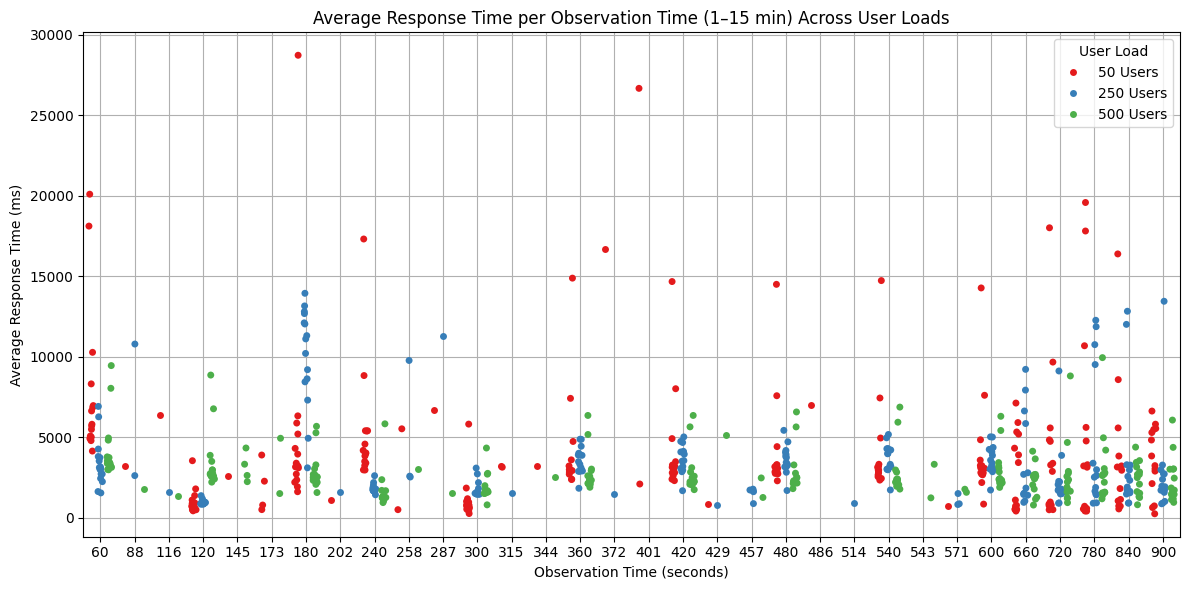

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df= pd.read_csv("/content/df_discrete_1_to_15_minutes.csv")

# Convert 'Users' to a labeled category
df['User_Load'] = df['Users'].astype(str) + ' Users'

# Plotting
plt.figure(figsize=(12, 6))
sns.stripplot(data=df,
              x='Observation_Time',
              y='Average Response Time',
              hue='User_Load',
              dodge=True,
              jitter=0.2,
              palette='Set1')

plt.title("Average Response Time per Observation Time (1–15 min) Across User Loads")
plt.xlabel("Observation Time (seconds)")
plt.ylabel("Average Response Time (ms)")
plt.grid(True)
plt.legend(title='User Load')
plt.tight_layout()
plt.show()


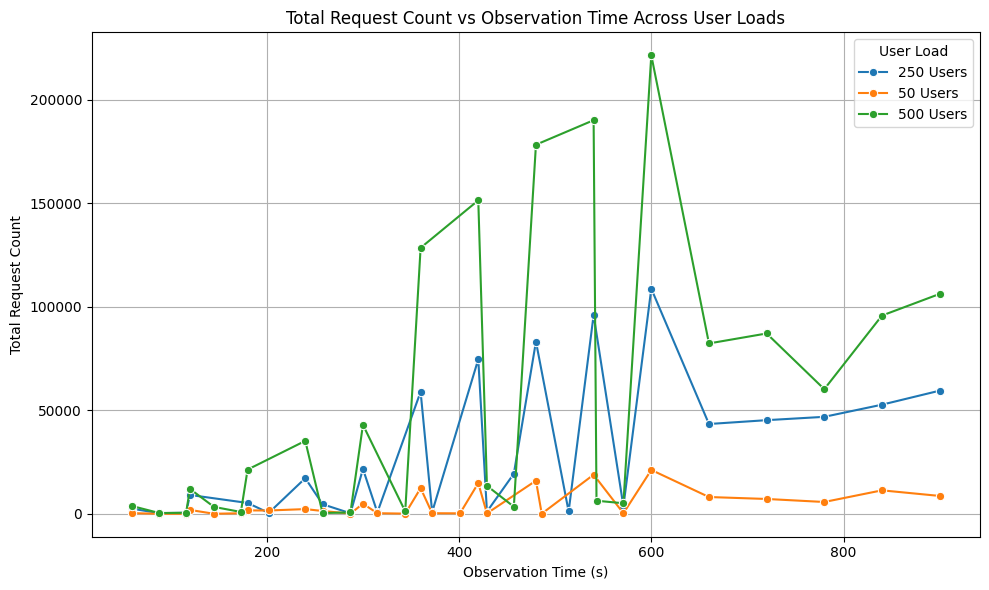

In [14]:
df= pd.read_csv("/content/df_discrete_1_to_15_minutes.csv")
# Convert 'Users' to a labeled category
df['User_Load'] = df['Users'].astype(str) + ' Users'
request_summary = df.groupby(['User_Load', 'Observation_Time'])['Request Count'].sum().reset_index()

# Plot Request Count
plt.figure(figsize=(10, 6))
sns.lineplot(data=request_summary, x='Observation_Time', y='Request Count', hue='User_Load', marker='o')
plt.title("Total Request Count vs Observation Time Across User Loads")
plt.xlabel("Observation Time (s)")
plt.ylabel("Total Request Count")
plt.grid(True)
plt.legend(title="User Load")
plt.tight_layout()
plt.show()

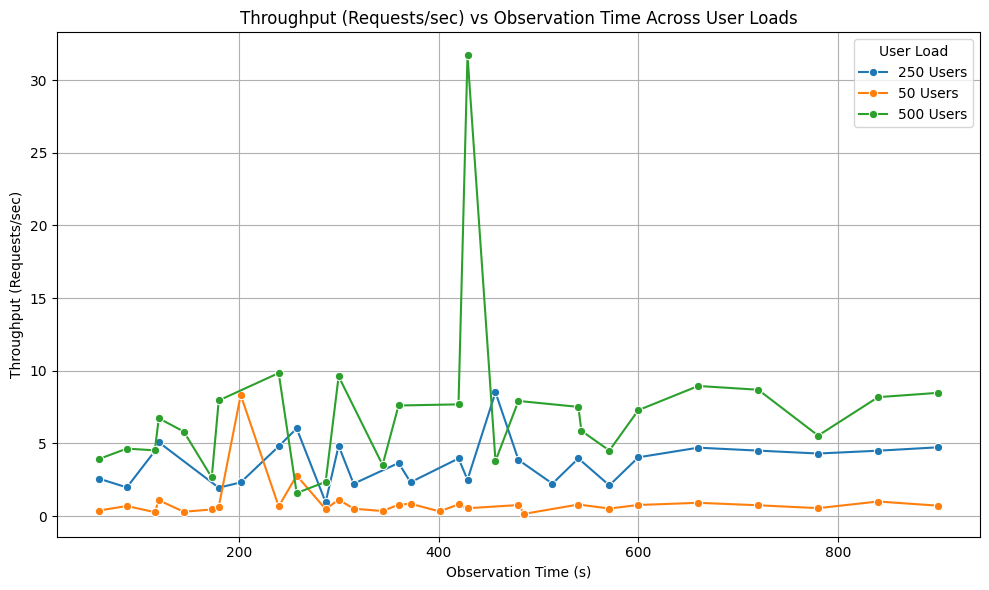

In [15]:
df= pd.read_csv("/content/df_discrete_1_to_15_minutes.csv")
# Convert 'Users' to a labeled category
df['User_Load'] = df['Users'].astype(str) + ' Users'
# Group by User_Load and Observation_Time, then average the throughput (assuming column is 'Requests/s')
throughput_summary = df.groupby(['User_Load', 'Observation_Time'])['Requests/s'].mean().reset_index()

# Plot Throughput
plt.figure(figsize=(10, 6))
sns.lineplot(data=throughput_summary, x='Observation_Time', y='Requests/s', hue='User_Load', marker='o')
plt.title("Throughput (Requests/sec) vs Observation Time Across User Loads")
plt.xlabel("Observation Time (s)")
plt.ylabel("Throughput (Requests/sec)")
plt.grid(True)
plt.legend(title="User Load")
plt.tight_layout()
plt.show()

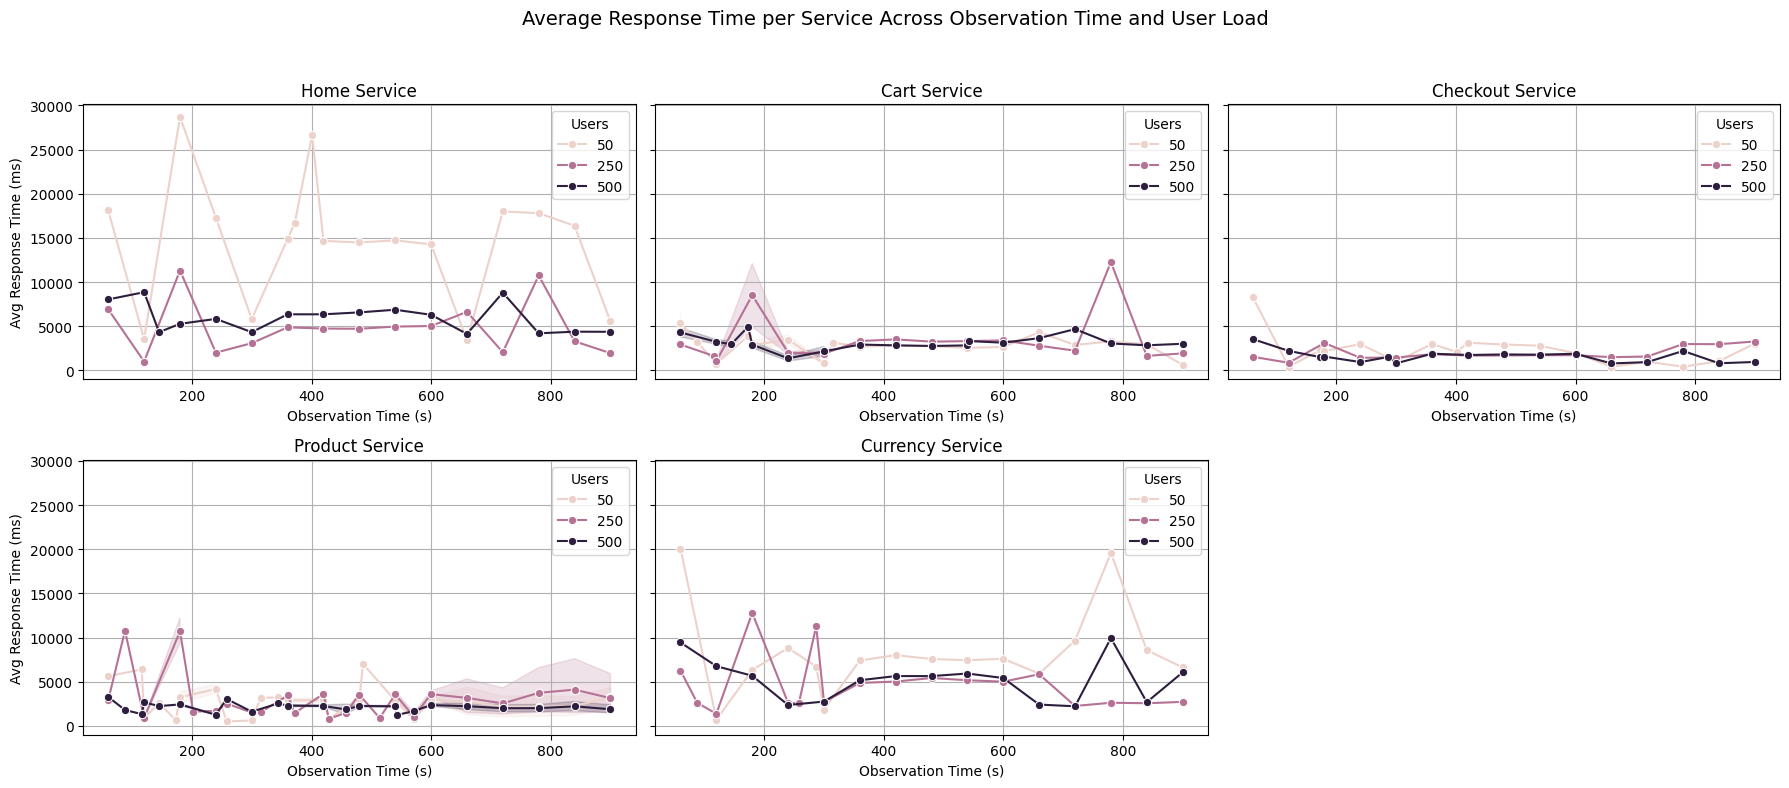

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("df_discrete_1_to_15_minutes.csv")  # Replace with your actual path

# Step 1: Classify endpoints into services
def classify_service(endpoint):
    if endpoint == '/':
        return 'Home'
    elif '/cart/checkout' in endpoint:
        return 'Checkout'
    elif '/cart' in endpoint:
        return 'Cart'
    elif '/product' in endpoint:
        return 'Product'
    elif '/setCurrency' in endpoint:
        return 'Currency'
    return 'Other'

df['Service'] = df['Name'].apply(classify_service)
df = df[df['Service'] != 'Other']  # Drop unrelated endpoints

# Step 2: Create a 3x2 grid of subplots
services = ['Home', 'Cart', 'Checkout', 'Product', 'Currency']
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharey=True)

# Step 3: Flatten axes and hide any unused ones
axes = axes.flatten()

# Plot for each service
for idx, service in enumerate(services):
    service_data = df[df['Service'] == service]
    sns.lineplot(data=service_data,
                 x='Observation_Time',
                 y='Average Response Time',
                 hue='Users',
                 marker='o',
                 ax=axes[idx])
    axes[idx].set_title(f"{service} Service")
    axes[idx].set_xlabel("Observation Time (s)")
    axes[idx].set_ylabel("Avg Response Time (ms)")
    axes[idx].grid(True)
    axes[idx].legend(title="Users", loc="upper right")

# Hide the 6th empty subplot (since we only have 5 services)
if len(services) < len(axes):
    axes[-1].set_visible(False)

# Final formatting
plt.suptitle("Average Response Time per Service Across Observation Time and User Load", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
